In [3]:
!pip install tf2onnx

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import cifar10, cifar100
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50, EfficientNetB2, MobileNetV3Small
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tqdm import tqdm
import tf2onnx

In [4]:
# Load CIFAR-10 dataset
img_size = 112
batch_size = 32
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Resize CIFAR-10 images to match MobileNetV2 input shape (224, 224)
train_images = tf.image.resize(train_images, (img_size, img_size))
test_images = tf.image.resize(test_images, (img_size, img_size))

# Convert class vectors to binary class matrices
num_classes = 10
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)
# train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
# test_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

170498071/170498071 [==============================] - 3s 0us/step


In [27]:
model_type = 'MobileNetV3Small'

if model_type == 'MobileNetV3Small':
    base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
elif model_type == 'EfficientNetB2':
    base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
elif model_type == 'ResNet50':
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
else:
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Add new classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Combine base model and new layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers in base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [29]:
# Train the model
epochs = 10
model.fit(train_dataset, epochs=epochs, batch_size=batch_size, validation_data=test_dataset)

Epoch 1/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.3730 - accuracy: 0.8662 - val_loss: 0.5235 - val_accuracy: 0.8263
Epoch 2/10
1563/1563 [==============================] - 16s 10ms/step - loss: 0.3582 - accuracy: 0.8721 - val_loss: 0.5159 - val_accuracy: 0.8318
Epoch 3/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.3415 - accuracy: 0.8779 - val_loss: 0.5356 - val_accuracy: 0.8270
Epoch 4/10
1563/1563 [==============================] - 16s 11ms/step - loss: 0.3306 - accuracy: 0.8820 - val_loss: 0.5300 - val_accuracy: 0.8325
Epoch 5/10
1563/1563 [==============================] - 16s 11ms/step - loss: 0.3206 - accuracy: 0.8846 - val_loss: 0.5211 - val_accuracy: 0.8299
Epoch 6/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.3034 - accuracy: 0.8912 - val_loss: 0.5281 - val_accuracy: 0.8344
Epoch 7/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.2965 - accuracy: 0.8922 - val_loss: 0.5187 -

In [30]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_dataset)
print('Test accuracy:', test_acc)

313/313 [==============================] - 3s 9ms/step - loss: 0.5516 - accuracy: 0.8365
Test accuracy: 0.8364999890327454


In [31]:
# Save the entire model to a HDF5 file
model.save('tf_{}_cifar10_model.h5'.format(model_type))
print("Model saved successfully.")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully.


In [32]:
# Load the model
model = tf.keras.models.load_model('tf_{}_cifar10_model.h5'.format(model_type))
print("Model loaded successfully.")

Model loaded successfully.


In [33]:
# Convert the model to TensorFlow Lite with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

# Define a generator function to provide calibration data
def representative_data_gen():
    for images, _ in train_dataset.take(100):
        yield [images.numpy().astype(np.float32)]

converter.representative_dataset = representative_data_gen

# Convert the model to TensorFlow Lite
tflite_quant_model = converter.convert()

# Save the quantized model to a file
with open('quantized_{}_cifar10_model.tflite'.format(model_type), 'wb') as f:
    f.write(tflite_quant_model)

print("Quantized model saved as quantized_{}_cifar10_model.tflite".format(model_type))

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Quantized model saved as quantized_MobileNetV3Small_cifar10_model.tflite


In [ ]:
# Load the quantized model
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]
print(input_details['shape'])
# Evaluate the model on the test dataset
total_accuracy = 0.0
num_eval_samples = 0

for test_image, test_label in tqdm(zip(test_images, test_labels)):
# for test_image, test_label in test_dataset:
    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    # Add batch dimension
    # print(test_image.shape)
    test_image = np.expand_dims(test_image.numpy(), axis=0).astype(input_details["dtype"])

    interpreter.set_tensor(input_details['index'], test_image)
    interpreter.invoke()

    # Get output tensor
    output = interpreter.get_tensor(output_details['index'])

    # Compare prediction to true label
    predicted_label = np.argmax(output)
    true_label = np.argmax(test_label)
    if predicted_label == true_label:
        total_accuracy += 1

    num_eval_samples += 1

# Calculate overall accuracy
accuracy = total_accuracy / num_eval_samples
print("Accuracy:", accuracy)

In [35]:
# Convert the model to TensorFlow Lite with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
# converter.inference_input_type = tf.float16
# converter.inference_output_type = tf.float16

# Define a generator function to provide calibration data
def representative_data_gen():
    for images, _ in train_dataset.take(100):
        yield [images.numpy().astype(np.float32)]

converter.representative_dataset = representative_data_gen

# Convert the model to TensorFlow Lite
tflite_fp16_model = converter.convert()

# Save the quantized model to a file
with open('quantized_{}_fp16_cifar10_model.tflite'.format(model_type), 'wb') as f:
    f.write(tflite_fp16_model)

print("Quantized model saved as quantized_{}_fp16_cifar10_model.tflite".format(model_type))

Quantized model saved as quantized_MobileNetV3Small_fp16_cifar10_model.tflite


In [36]:
# Convert the model to TensorFlow Lite with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8,
                                       tf.lite.OpsSet.TFLITE_BUILTINS]

# Define a generator function to provide calibration data
def representative_data_gen():
    for images, _ in train_dataset.take(100):
        yield [images.numpy().astype(np.float32)]

converter.representative_dataset = representative_data_gen

# Convert the model to TensorFlow Lite
tflite_int16_model = converter.convert()

# Save the quantized model to a file
with open('quantized_{}_int16_cifar10_model.tflite'.format(model_type), 'wb') as f:
    f.write(tflite_int16_model)

print("Quantized model saved as quantized_{}_int16_cifar10_model.tflite".format(model_type))

Quantized model saved as quantized_MobileNetV3Small_int16_cifar10_model.tflite


In [37]:
def evaluate_quant_model(quant_model):
  # Load the quantized model
  interpreter = tf.lite.Interpreter(model_content=quant_model)
  interpreter.allocate_tensors()

  # Get input and output details
  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]
  # Evaluate the model on the test dataset
  total_accuracy = 0.0
  num_eval_samples = 0

  for test_image, test_label in tqdm(zip(test_images, test_labels)):
    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    # Add batch dimension
    # print(test_image.shape)
    test_image = np.expand_dims(test_image.numpy(), axis=0).astype(input_details["dtype"])

    interpreter.set_tensor(input_details['index'], test_image)
    interpreter.invoke()

    # Get output tensor
    output = interpreter.get_tensor(output_details['index'])

    # Compare prediction to true label
    predicted_label = np.argmax(output)
    true_label = np.argmax(test_label)
    if predicted_label == true_label:
        total_accuracy += 1

    num_eval_samples += 1

  # Calculate overall accuracy
  accuracy = total_accuracy / num_eval_samples
  print("Accuracy:", accuracy)

In [38]:
print("FP16 Accuracy")
evaluate_quant_model(tflite_fp16_model)
print("INT8 Accuracy")
evaluate_quant_model(tflite_quant_model)
print("INT16 Accuracy")
evaluate_quant_model(tflite_int16_model)

FP16 Accuracy


10000it [00:18, 548.52it/s]


Accuracy: 0.8368
INT8 Accuracy


10000it [00:37, 267.76it/s]


Accuracy: 0.4526
INT16 Accuracy


10000it [03:39, 45.59it/s]

Accuracy: 0.7979


In [25]:
def evaluate_quant_model(quant_model, test_dataset):
    # Load the quantized model
    interpreter = tf.lite.Interpreter(model_content=quant_model)
    interpreter.allocate_tensors()

    # Get input and output details
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    # Evaluate the model on the test dataset
    total_accuracy = 0.0
    num_eval_samples = 0

    for test_image_batch, test_label_batch in tqdm(test_dataset):
        batch_size = test_image_batch.shape[0]

        # Check if the input type is quantized, then rescale input data to uint8
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            test_image_batch = test_image_batch / input_scale + input_zero_point


        # Add batch dimension
        test_image_batch = test_image_batch.numpy().astype(input_details["dtype"])

        # Set input tensor
        interpreter.set_tensor(input_details['index'], test_image_batch)

        # Run inference
        interpreter.invoke()

        # Get output tensor
        output_batch = interpreter.get_tensor(output_details['index'])

        # Compare prediction to true label
        predicted_labels = np.argmax(output_batch, axis=1)
        true_labels = np.argmax(test_label_batch.numpy(), axis=1)

        # Calculate accuracy for this batch
        batch_accuracy = np.mean(np.equal(predicted_labels, true_labels))

        # Update total accuracy and number of samples
        total_accuracy += batch_accuracy * batch_size
        num_eval_samples += batch_size

    # Calculate overall accuracy
    accuracy = total_accuracy / num_eval_samples
    print("Accuracy:", accuracy)

In [ ]:
print("FP16 Accuracy")
evaluate_quant_model(tflite_fp16_model, test_dataset)
print("INT8 Accuracy")
evaluate_quant_model(tflite_quant_model, test_dataset)
print("INT16 Accuracy")
evaluate_quant_model(tflite_int16_model, test_dataset)

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
# Convert the model to TensorFlow Lite with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
# Define a generator function to provide calibration data
def representative_data_gen():
    for images, _ in train_dataset.take(100):
        yield [images.numpy().astype(np.float32)]

converter.representative_dataset = representative_data_gen

debugger = tf.lite.experimental.QuantizationDebugger(
    converter=converter, debug_dataset=converter.representative_dataset)

debugger.run()

RESULTS_FILE = 'debugger_results.csv'
with open(RESULTS_FILE, 'w') as f:
  debugger.layer_statistics_dump(f)

layer_stats = pd.read_csv(RESULTS_FILE)
layer_stats.head()

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


,op_name,tensor_idx,num_elements,stddev,mean_error,max_abs_error,mean_squared_error,scale,zero_point,tensor_name
0,MUL,233,1204224.0,3.907464e-03,-8.082945e-06,0.007843,1.526868e-05,0.011765,-43,model_1/rescaling_1/mul
1,ADD,237,1204224.0,1.852267e-03,1.317683e-03,0.003922,5.167414e-06,0.007843,-1,model_1/rescaling_1/add
2,CONV_2D,241,1605632.0,2.438858e-02,7.999366e-04,0.074648,5.955087e-04,0.083595,-80,model_1/Conv/BatchNorm/FusedBatchNormV3;model_...
3,HARD_SWISH,245,1605632.0,1.896683e-02,3.963854e-03,0.034734,3.754979e-04,0.069208,-123,model_1/multiply_18/mul;model_1/tf.__operators...
4,PAD,249,1663488.0,2.236330e-07,3.379920e-07,0.000001,1.642555e-13,0.069208,-123,model_1/expanded_conv/depthwise/pad/Pad


In [41]:
layer_stats['range'] = 255.0 * layer_stats['scale']
layer_stats['rmse/scale'] = layer_stats.apply(
    lambda row: np.sqrt(row['mean_squared_error']) / row['scale'], axis=1)
layer_stats[['op_name', 'range', 'rmse/scale']].head()

,op_name,range,rmse/scale
0,MUL,3.000000,0.332139
1,ADD,2.000000,0.289832
2,CONV_2D,21.316819,0.291919
3,HARD_SWISH,17.647997,0.279994
4,PAD,17.647997,0.000006


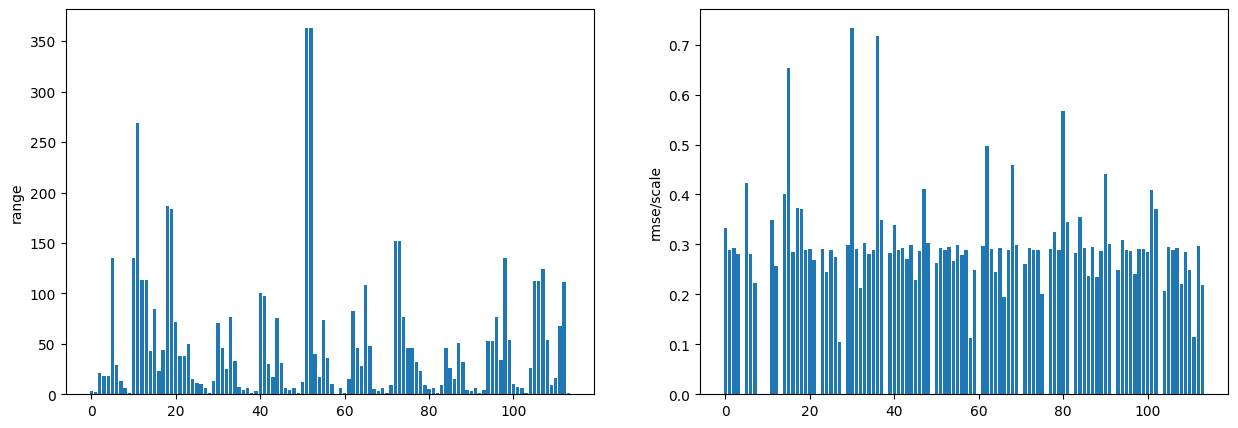

In [42]:
plt.figure(figsize=(15, 5))
ax1 = plt.subplot(121)
ax1.bar(np.arange(len(layer_stats)), layer_stats['range'])
ax1.set_ylabel('range')
ax2 = plt.subplot(122)
ax2.bar(np.arange(len(layer_stats)), layer_stats['rmse/scale'])
ax2.set_ylabel('rmse/scale')
plt.show()

In [43]:
suspected_layers = list(
    layer_stats[layer_stats['rmse/scale'] > 0.5]['tensor_name'])

suspected_layers.extend(list(layer_stats[:3]['tensor_name']))
suspected_layers.extend(list(layer_stats[:-3]['tensor_name']))

print(suspected_layers)

['model_1/expanded_conv_1/project/BatchNorm/FusedBatchNormV3;model_1/expanded_conv_3/squeeze_excite/Conv/Conv2D;model_1/expanded_conv_1/project/Conv2D', 'model_1/expanded_conv_3/project/BatchNorm/FusedBatchNormV3;model_1/expanded_conv_7/squeeze_excite/Conv/Conv2D;model_1/expanded_conv_3/project/Conv2D', 'model_1/expanded_conv_4/squeeze_excite/Relu/Relu;model_1/expanded_conv_4/squeeze_excite/Conv/BiasAdd;model_1/expanded_conv_5/squeeze_excite/Conv/Conv2D;model_1/expanded_conv_4/squeeze_excite/Conv/Conv2D;model_1/expanded_conv_4/squeeze_excite/Conv/BiasAdd/ReadVariableOp', 'model_1/expanded_conv_8/squeeze_excite/Relu/Relu;model_1/expanded_conv_8/squeeze_excite/Conv/BiasAdd;model_1/expanded_conv_8/squeeze_excite/Conv/Conv2D;model_1/expanded_conv_8/squeeze_excite/Conv/BiasAdd/ReadVariableOp', 'model_1/rescaling_1/mul', 'model_1/rescaling_1/add', 'model_1/Conv/BatchNorm/FusedBatchNormV3;model_1/expanded_conv/project/Conv2D;model_1/Conv/Conv2D', 'model_1/rescaling_1/mul', 'model_1/rescaling_

In [44]:
debug_options = tf.lite.experimental.QuantizationDebugOptions(
    denylisted_nodes=suspected_layers)
debugger = tf.lite.experimental.QuantizationDebugger(
    converter=converter,
    debug_dataset=representative_data_gen,
    debug_options=debug_options)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [45]:
selective_quantized_model = debugger.get_nondebug_quantized_model()
# Save the quantized model to a file
with open('selective_quantized_{}_cifar10_model.tflite'.format(model_type), 'wb') as f:
    f.write(tflite_int16_model)

print("Quantized model saved as selective_quantized_{}_cifar10_model.tflite".format(model_type))

Quantized model saved as selective_quantized_MobileNetV3Small_cifar10_model.tflite


In [46]:
print("Selective Quantization (FP132 + INT8) Accuracy")
evaluate_quant_model(selective_quantized_model)

Selective Quantization (FP132 + INT8) Accuracy


10000it [00:18, 547.67it/s]

Accuracy: 0.8347


In [39]:
# Load the quantized model
interpreter = tf.lite.Interpreter(model_content=tflite_fp16_model)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]
print(input_details['shape'])
# Evaluate the model on the test dataset
total_accuracy = 0.0
num_eval_samples = 0

for test_image, test_label in tqdm(zip(test_images, test_labels)):
# for test_image, test_label in test_dataset:
    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    # Add batch dimension
    # print(test_image.shape)
    test_image = np.expand_dims(test_image.numpy(), axis=0).astype(input_details["dtype"])

    interpreter.set_tensor(input_details['index'], test_image)
    interpreter.invoke()

    # Get output tensor
    output = interpreter.get_tensor(output_details['index'])

    # Compare prediction to true label
    predicted_label = np.argmax(output)
    true_label = np.argmax(test_label)
    if predicted_label == true_label:
        total_accuracy += 1

    num_eval_samples += 1

# Calculate overall accuracy
accuracy = total_accuracy / num_eval_samples
print("Accuracy:", accuracy)

[  1 112 112   3]


10000it [08:03, 20.67it/s]

Accuracy: 0.8028
